[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/caer200/ocelotml_2d/blob/main/first_gen_models.ipynb)

# Install the required packages


In [4]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 29.5 MB 1.6 MB/s 


In [5]:
import matplotlib.pyplot as plt
import json
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
import pandas as pd
from tqdm import tqdm
import rdkit.Chem as Chem
import numpy as np


# Get the OCELOT ML library

In [2]:
!git clone https://github.com/caer200/ocelotml_2d.git

Cloning into 'ocelotml_2d'...
remote: Enumerating objects: 73, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 73 (delta 4), reused 1 (delta 1), pack-reused 68
Unpacking objects: 100% (73/73), done.


# Get the model parameters 

In [1]:
import requests, zipfile, io

def get_models():
  MODELS_URL = "https://drive.google.com/uc?export=download&id=1FfGyJ-ZLfb_vdk6-05TsfH0W2ZIk9T4f&confirm=f"
  r = requests.get(MODELS_URL)
  z = zipfile.ZipFile(io.BytesIO(r.content))
  z.extractall("models")

get_models()

# Define training functions

In [6]:
from ocelotml_2d.mlp_features import *

def plot_pred_true(true, pred):
  plt.scatter(true, pred)
  plt.xlabel("True values (eV)")
  plt.ylabel("Predicted values (eV)")
  plt.show()

def prepare_data(model_name, data_frame, fp=None):
  train = data_frame.sample(frac = 0.8)
  test = data_frame.loc[~data_frame.index.isin(train.index)]
  train_smiles = train.smiles
  test_smiles = test.smiles
  mtype = model_name.split("_")[0]
  #skip = F"{mtype}_with_fp_" if "with" in model_name else F"{mtype}_no_fp_"
  data_name = model_name.split("_")[0]
  #data_name = model_name.replace(skip, "")
  train_data = np.array(train[data_name])
  test_data = np.array(test[data_name])
  mol_train = [Chem.MolFromSmiles(mol) for mol in tqdm(train_smiles, desc = "Making training molecules")]
  mol_test = [Chem.MolFromSmiles(mol) for mol in tqdm(test_smiles, desc = "Making testing molecules")]

  train_feats = [molecule_descriptors(mol, fp=fp) for mol in tqdm(mol_train, desc = "Making training features")]
  test_feats = [molecule_descriptors(mol, fp=fp) for mol in tqdm(mol_test, desc = "Making training features")]
  return train_feats, test_feats, train_data, test_data



def SVM_training(xtrain, xtest, ytrain, ytest, params, plot=True, return_fitted=False):
  reg = SVR(**params)
  reg.fit(xtrain, ytrain)
  my_pred = reg.predict(xtest)
  r2 = r2_score(ytest, my_pred)
  MAE = mean_absolute_error(ytest, my_pred)
  if plot:
    plot_pred_true(ytest, my_pred)
  if return_fitted:
    return round(r2, 3), round(MAE, 3), reg
  else:
    return round(r2, 3), round(MAE, 3), None

  
def KRR_training(xtrain, xtest, ytrain, ytest, params, plot=True, return_fitted=False):
  reg = KernelRidge(**params)
  reg.fit(xtrain, ytrain)
  my_pred = reg.predict(xtest)
  r2 = r2_score(ytest, my_pred)
  MAE = mean_absolute_error(ytest, my_pred)
  if plot:
    plot_pred_true(ytest, my_pred)
  if return_fitted:
    return round(r2, 3), round(MAE, 3), reg
  else:
    return round(r2, 3), round(MAE, 3), None

def Ridge_regression_training(xtrain, xtest, ytrain, ytest, params, plot=True, return_fitted = False):
  reg = Ridge(**params)
  reg.fit(xtrain, ytrain)
  my_pred = reg.predict(xtest)
  r2 = r2_score(ytest, my_pred)
  MAE = mean_absolute_error(ytest, my_pred)
  if plot:
    plot_pred_true(ytest, my_pred)
  if return_fitted:
    return round(r2, 3), round(MAE, 3), reg
  else:
    return round(r2, 3), round(MAE, 3), None

def prediction_from_fitted_model(molecule, model, fp=None):
  if model is None:
    print("Needs a trained model, set get_back_trained_model to True")
    return None
  mol = Chem.MolFromSmiles(molecule)
  if mol is None:
    print(F"Molecule {molecule} is not valid!")
    return None
  feats = np.array(molecule_descriptors(mol, fp = fp))
  prediction = model.predict([feats])
  return round(prediction[0], 3)
  

def define_model(name, plot=True, return_fitted=True, partial_amount = None):
  try:
    with open(F"models/ocelotml_2d/{name}/params.json", "r") as file:
      param_d = json.load(file)
  except FileNotFoundError:
    print(F"Model {name} does not exist")
    return (None, None, None), None
  if "FP" in name:
    fp = param_d.pop("fp_length")
  else:
    fp = None
  if partial_amount:

    df = pd.read_csv("https://drive.google.com/uc?export=download&id=1zrb9HfWR-ydyf3WxoDMZQZxcSx3Q_JGh", index_col=0).iloc[:partial_amount]
  else:
    df = pd.read_csv("https://drive.google.com/uc?export=download&id=1zrb9HfWR-ydyf3WxoDMZQZxcSx3Q_JGh", index_col=0)
  xtr, xt, ytr, yt = prepare_data(name, df, fp=fp)
  if "svm" in name:
    return SVM_training(xtr, xt, ytr, yt, param_d, plot, return_fitted), fp
  elif "krr" in name:
    return KRR_training(xtr, xt, ytr, yt, param_d, plot, return_fitted), fp
  elif "ridge" in name:
    return Ridge_regression_training(xtr, xt, ytr, yt, param_d, plot, return_fitted), fp
  

  


# Train a model!

A model can be chosen with the following architectures:


1.   Support Vector Machine (svm)
2.   Kernel Ridge Regression (krr)
3.   Ridge Regression (ridge)

Model names have the format {target}\_1gen_\{model}\_{FP?}
Example: 


*   Training a LUMO model without fingerprints with Ridge Regression
      *   lumo\_1gen\_ridge 
*   Training a model for AEA with fingerprints using Support Vector Machine
      *   aea\_1gen\_svm\_FP

It will take a bit to train these models! But relax, they're worth the wait 😎
(KRR models may take very long)


Making training features: 100%|██████████| 5050/5050 [00:24<00:00, 206.38it/s]


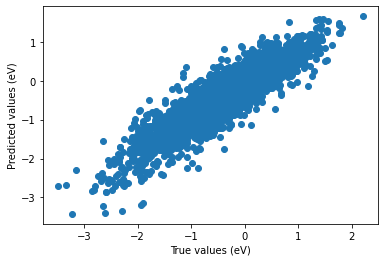

The r^2 for vea_1gen_ridge_FP is 0.815 and the MAE is 0.221 eV


In [7]:
model_selection = "vea_1gen_ridge_FP"

plot_result = True
get_back_trained_model = True

partial_amount = None # set this equal to some number if you don't have the time to wait for the full set to train
#ex: partial_amount = 1000 will only use the first 1,000 points from the ocelot_chromophore_v1 dataset
#be warned, training on partial subsets of data will yield a worse model than training on the full set!

training_output,fp_len = define_model(model_selection, plot_result, get_back_trained_model, partial_amount = partial_amount)
r2, mae, trained_model = training_output


print(F"The r^2 for {model_selection} is {r2} and the MAE is {mae} eV")



In [8]:

my_molecule = "c1ccccc1"


my_prediction = prediction_from_fitted_model(my_molecule, trained_model, fp_len)


print(F"{model_selection} predicts the value of {my_prediction} for {my_molecule}")

vea_1gen_ridge_FP predicts the value of 1.292 for c1ccccc1
